# Assignment on Regularization and Optimization of Deep Learning

이번 과제에서는 reagularization과 optimization에서 배운 내용들을 이용해 최대한 Deep Models의 성능을 높여보고자 합니다. Layer 4개짜리 MLP (각 hidden layer는 512개의 unit을 가짐) 상황에서 정규화와 최적화 방법론들을 총 동원해 성능을 높여주시면 됩니다.

먼저, 아래 코드는 데이터 셋을 셋팅하는 부분입니다. 이 부분은 건드리시면 안됩니다. 이 부분을 건드리시면 0점 처리 됩니다. 외부 데이터 사용하셔도 안됩니다.

In [1]:
%matplotlib inline
import math
import random 

import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt

from tensorflow import keras

seed = 1
random.seed(seed)
np.random.seed(seed=seed)
tf.random.set_random_seed(seed)

(x_1, y_1), (x_2, y_2) = tf.keras.datasets.cifar100.load_data()
x_total = np.concatenate([x_1, x_2], axis=0).astype(np.float64)
y_total = np.concatenate([y_1, y_2], axis=0)

n_output = 10

valid_index, _ = np.where(y_total < n_output)
y_total = y_total[valid_index].reshape([-1])
x_total = x_total[valid_index]

i = np.arange(x_total.shape[0])
np.random.shuffle(i)
x_total = x_total[i]
y_total = y_total[i]

train_size = 100 * n_output
x_train = x_total[:train_size]
y_train = y_total[:train_size]
x_test = x_total[train_size:]
y_test = y_total[train_size:]

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1000, 32, 32, 3)
(1000,)
(5000, 32, 32, 3)
(5000,)


validation set을 나눕니다. 
- 실습시간에 배웠던 것처럼 Validation set 비율은 조정하셔도 됩니다. 

In [2]:
split = x_train.shape[0] // 5
x_valid = x_train[:split]
y_valid = y_train[:split]

x_train = x_train[split:]
y_train = y_train[split:]

(800, 32, 32, 3)
(800, 100)


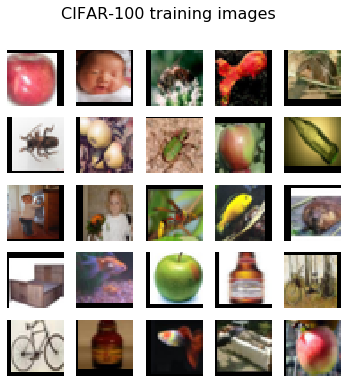

In [3]:
x_train_t = x_train / 255.0
y_train_t = tf.keras.utils.to_categorical(y_train, 10)

batch_size = len(x_train)

datagen_c100 = tf.keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=5,
    height_shift_range=5,
    fill_mode='constant',
    horizontal_flip=True).flow(x_train_t, y_train_t, batch_size=batch_size)


for x, y in datagen_c100:
    plt.figure(figsize=(6,6))
    plt.suptitle('CIFAR-100 training images', fontsize=16)
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.imshow(x[i])
        plt.axis('off')
    break


print(x_train_t.shape)
print(y_train_t.shape)

x_train.append(datagen_c100)

이미지를 greyscale로 변경합니다. 
1. RGB 값을 고려한 코드로 변경하셔도 됩니다. 
2. Augmentation을 고려해보세요.

In [4]:
x_train = np.mean(x_train, axis=3)
x_valid = np.mean(x_valid, axis=3)
x_test = np.mean(x_test, axis=3)

print(x_train.shape)
print(x_valid.shape)
print(x_test.shape)
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

n_input = 32 * 32

x_train = x_train.reshape([-1, n_input])
x_valid = x_valid.reshape([-1, n_input])
x_test = x_test.reshape([-1, n_input])

print(x_train.shape)
print(x_valid.shape)
print(x_test.shape)


(800, 32, 32)
(200, 32, 32)
(5000, 32, 32)
(800,)
(200,)
(5000,)
(800, 1024)
(200, 1024)
(5000, 1024)


이제 모델을 만듭니다.

1. Optimizer를 다른 걸로 바꿔보세요
2. Learning Rate를 바꿔보세요. Learning Rate Scheduling도 고려해보세요.
3. Activation Function을 바꿔보세요. 
4. Dropout, DropConnect, Gaussian Dropout 을 고려해보세요.
5. Augmentation을 고려해보세요. 

In [5]:
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.int32, [None])
training = tf.placeholder(tf.bool)

n_units = [n_input, 512, 512, 512, n_output]

weights, biases = [], []
for i, (n_in, n_out) in enumerate(zip(n_units[:-1], n_units[1:])):
    stddev = math.sqrt(2 / n_in) # Kaiming He Initialization
    weight = tf.Variable(tf.random.truncated_normal([n_in, n_out], mean=0, stddev=stddev))
    bias = tf.Variable(tf.zeros([n_out]))
    weights.append(weight)
    biases.append(bias)    
    
#layer = x 
#augmentation - adding noise "stddev=50"
layer = x + tf.cond(training, lambda: tf.random.normal(tf.shape(x), mean=0.0, stddev=50), lambda: tf.zeros_like(x))


for i, (weight, bias) in enumerate(zip(weights, biases)):
    layer = tf.matmul(layer, weight) + bias
    if i < len(weights) - 1:
        
        layer = tf.nn.tanh(layer) 
        # layer = tf.nn.sigmoid(layer)
        # layer = tf.nn.relu(layer)
        
        layer = tf.keras.layers.GaussianDropout(rate=0.3)(layer, training=training)
        # layer = tf.nn.dropout(layer, keep_prob=0.5)*0.5   # Drop connect
        # layer = tf.layers.dropout(layer, rate=0.4, training=training)  # Drop out (layers Dropout)    
        
        
y_hat = layer

y_hot = tf.one_hot(y, n_output)
costs = tf.nn.softmax_cross_entropy_with_logits_v2(
        labels=y_hot, logits=y_hat)
cross_entropy_loss = tf.reduce_mean(costs)
loss = cross_entropy_loss 

y_label = tf.argmax(y_hat, 1)
accuracy = tf.count_nonzero(
        tf.cast(tf.equal(tf.argmax(y_hot, 1), y_label),
                tf.int64)) / tf.cast(tf.shape(y_hot)[0], tf.int64)

extra_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)


with tf.control_dependencies(extra_ops):     
    
    optimizer = tf.train.AdamOptimizer(1e-4)    
    # optimizer = tf.train.AdamOptimizer(1e-3)    
    # optimizer = tf.train.AdamOptimizer(1e-5)    
    # optimizer = tf.train.GradientDescentOptimizer(1e-4)
    # optimizer = tf.train.RMSPropOptimizer(1e-4)
    # optimizer = tf.train.AdagradOptimizer(1e-4)    
 
    train_op = optimizer.minimize(loss)

In [6]:
gpu_options = tf.GPUOptions()
gpu_options.allow_growth = True
session = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
session.run(tf.global_variables_initializer())

max_valid_epoch_idx = 0
max_valid_accuracy = 0.0
final_test_accuracy = 0.0
for epoch_idx in range(1, 10000 + 1):    
    
    
    session.run(
            train_op,
            feed_dict={
                x: x_train,
                y: y_train,
                training: True
            })
    
    if epoch_idx % 10 == 0:
        train_loss_value, train_accuracy_value = session.run(
            [loss, accuracy],
            feed_dict={
                x: x_train,
                y: y_train,
                training: False
            })
        
        valid_loss_value, valid_accuracy_value = session.run(
            [loss, accuracy],
            feed_dict={
                x: x_valid,
                y: y_valid,
                training: False
            })
            
        test_loss_value, test_accuracy_value = session.run(
            [loss, accuracy],
            feed_dict={
                x: x_test,
                y: y_test,
                training: False
            })

        print(epoch_idx, '%.4f' % train_loss_value, '%.4f' % valid_loss_value, '%.4f' % test_loss_value, '%.4f' % train_accuracy_value, '%.4f' % valid_accuracy_value, '%.4f' % test_accuracy_value)
        
        if max_valid_accuracy < valid_accuracy_value:
            max_valid_accuracy = valid_accuracy_value 
            max_valid_epoch_idx = epoch_idx
            final_test_accuracy = test_accuracy_value
            
    
    # Early Stop
    if max_valid_epoch_idx + 100 < epoch_idx:
        break
        
print(final_test_accuracy)

10 2.2339 2.3586 2.2976 0.1850 0.1350 0.1492
20 2.1121 2.2177 2.1897 0.2313 0.2150 0.2134
30 2.0408 2.1817 2.1591 0.2787 0.1950 0.2378
40 1.9902 2.1622 2.1358 0.3187 0.2300 0.2518
50 1.9523 2.2001 2.1269 0.3325 0.2100 0.2656
60 1.9388 2.1871 2.1252 0.3400 0.2300 0.2610
70 1.9235 2.1710 2.1258 0.3362 0.2150 0.2562
80 1.9103 2.1847 2.1248 0.3337 0.2400 0.2654
90 1.8806 2.1515 2.1176 0.3463 0.2700 0.2768
100 1.8856 2.1664 2.1180 0.3613 0.2500 0.2868
110 1.8581 2.1709 2.1091 0.3525 0.2550 0.2936
120 1.8446 2.1894 2.1019 0.3688 0.2500 0.2996
130 1.8372 2.1976 2.1139 0.3887 0.2400 0.2838
140 1.8247 2.1957 2.0935 0.3725 0.2150 0.2926
150 1.8137 2.2242 2.0951 0.3775 0.2300 0.3020
160 1.8008 2.2192 2.1075 0.3800 0.2550 0.3018
170 1.7988 2.2211 2.0964 0.3912 0.2700 0.3076
180 1.7842 2.2063 2.0956 0.3837 0.2550 0.3058
190 1.7745 2.1827 2.0858 0.3925 0.2650 0.3112
0.2768


32.88% 의 성능을 확인할 수 있습니다. 실습시간 배운 몇 가지 정규화와 최적화 과정을 동원하면 50% 정도의 성능까지는 쉽게 달성할 수 있음을 확인했습니다. 수업시간에 배운 내용들을 사용해 최대한 높은 성능을 나타내는 모델을 만들어보세요! 
주피터 노트북 파일을 제출해주시면 되며, 성능을 기준으로 점수를 매길 예정입니다. (상대평가)